## **Netflix Movie Clustering**

In this notebook we try to cluster netflix shows into various categories based on their description. We use K means clustering along with various text encoding techniques to find the the optimum number of separable clusters. 
The main metric used to evaluate a cluster is silhoutte score.

The following steps have been performed



1.   Importing Libraries
2.   Loading the Dataset
3.   Data cleaning and subsetting
4.   Data Visualizations 
5.   Text Preprocessing
6.   Implementing K means clustering using TF-IDF vectorization
7.   Tuning K Value 
8.   Validating results
9.   Implementing K means clustering using Doc2Vec word embedding
10.  Tuning K value
11.  Validaing results
12.  Implementing K means clustering using Auto Encoder word embedding
13.  Tuning K value
14.  Validaing results




### **Importing Libraries **

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import itertools as it
from collections import Counter
import pickle

# NLP libraries
import nltk
import re
import string

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn libraries
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score




### **Loading Dataset**

In [ ]:
netflix_titles = pd.read_csv("netflix_titles.csv")
print("Shape of the dataset: ",netflix_titles.shape)
netflix_titles.head()

Shape of the dataset:  (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### **Data Cleaning and Subsetting**

In [ ]:
print("Checking for duplicates \n")
print("Number of unique titles:",netflix_titles['title'].nunique())
print("Number of unique show Id:",netflix_titles['show_id'].nunique())
print("\n")

print("Checking for Nulls \n")
print(netflix_titles.isnull().sum())

#netflix_titles = netflix_titles[['show_id','title','description']]

Checking for duplicates 

Number of unique titles: 8807
Number of unique show Id: 8807


Checking for Nulls 

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


### **Data Visualization**

Text(0, 0.5, 'Ratio')

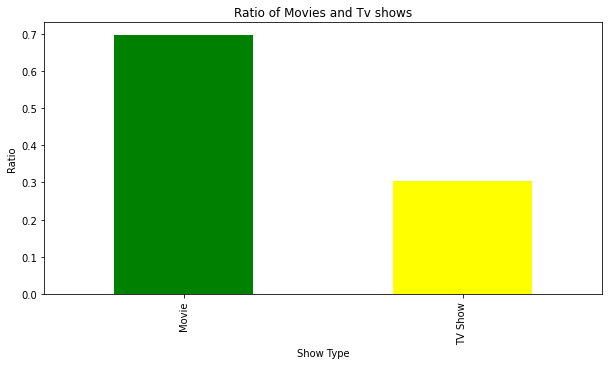

In [ ]:
movie_perc = netflix_titles['type'].value_counts()/netflix_titles.shape[0]
plot1 = movie_perc.plot.bar(color = ['green','yellow'],figsize = (10,5))
plt.title("Ratio of Movies and Tv shows")
plt.xlabel("Show Type")
plt.ylabel("Ratio")


Text(0, 0.5, 'Number of shows')

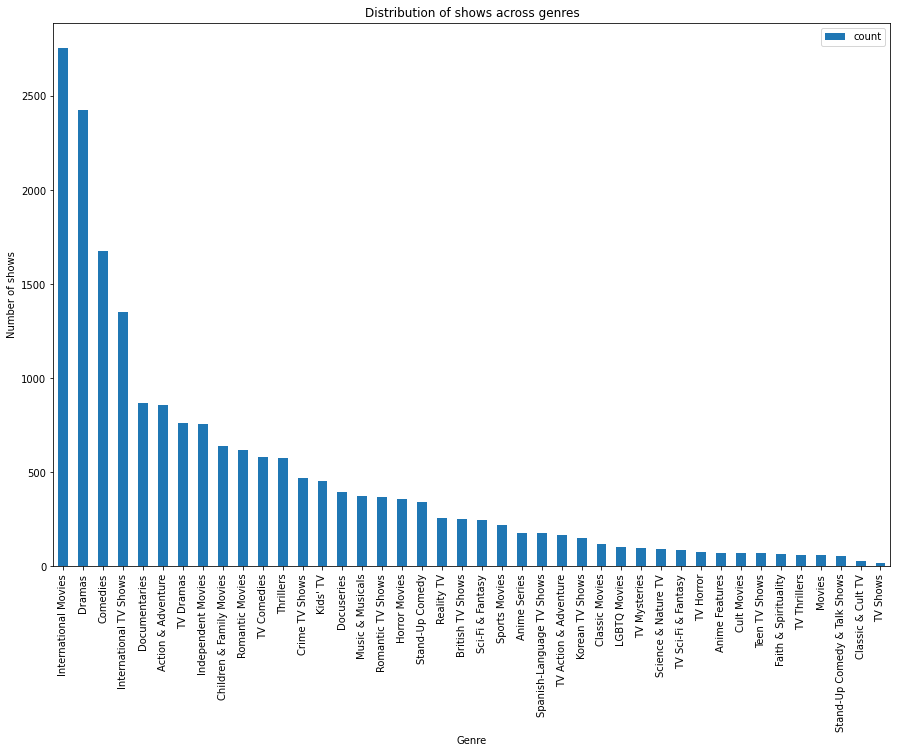

In [ ]:
genres = netflix_titles['listed_in']
genres = [x.split(', ') for x in genres]
genres_count = Counter(it.chain(*map(set, genres)))
genres_df = pd.DataFrame.from_dict(genres_count,orient='index').reset_index()
genres_df.columns = ['genres','count']
genres_df.sort_values(['count'],inplace = True,ascending = False)
genres_df.plot.bar(x = 'genres',y='count',figsize =(15,10) )
plt.title("Distribution of shows across genres")
plt.xlabel("Genre")
plt.ylabel("Number of shows")


### Glove Encodings

In [ ]:
### Pre Trained Sentence Glove Embeddings for the Dataset
with open('glove_embeddings.pkl', 'rb') as fp:
    glove_encodings = pickle.load(fp)
fp.close()

### SentenceBert Encodings

In [ ]:
### Pre Trained Sentence Bert Embeddings for the Dataset
with open('sentBert_embeddings_3.pkl', 'rb') as fp:
    sentBert_encodings = pickle.load(fp)
fp.close()

### t-SNE Visualization of the 2 encodings

In [ ]:
sc_X = StandardScaler()
glove_X = sc_X.fit_transform(glove_encodings)
bert_X = sc_X.fit_transform(sentBert_encodings)

In [ ]:
tsne = TSNE(n_components=2)
print("t-SNE of glove encodings")
tsne_mat_glove = tsne.fit_transform(glove_encodings)
print("t-SNE of sentenceBert ecodings")
tsne_mat_bert = tsne.fit_transform(sentBert_encodings)

t-SNE of glove encodings


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE of sentenceBert ecodings


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


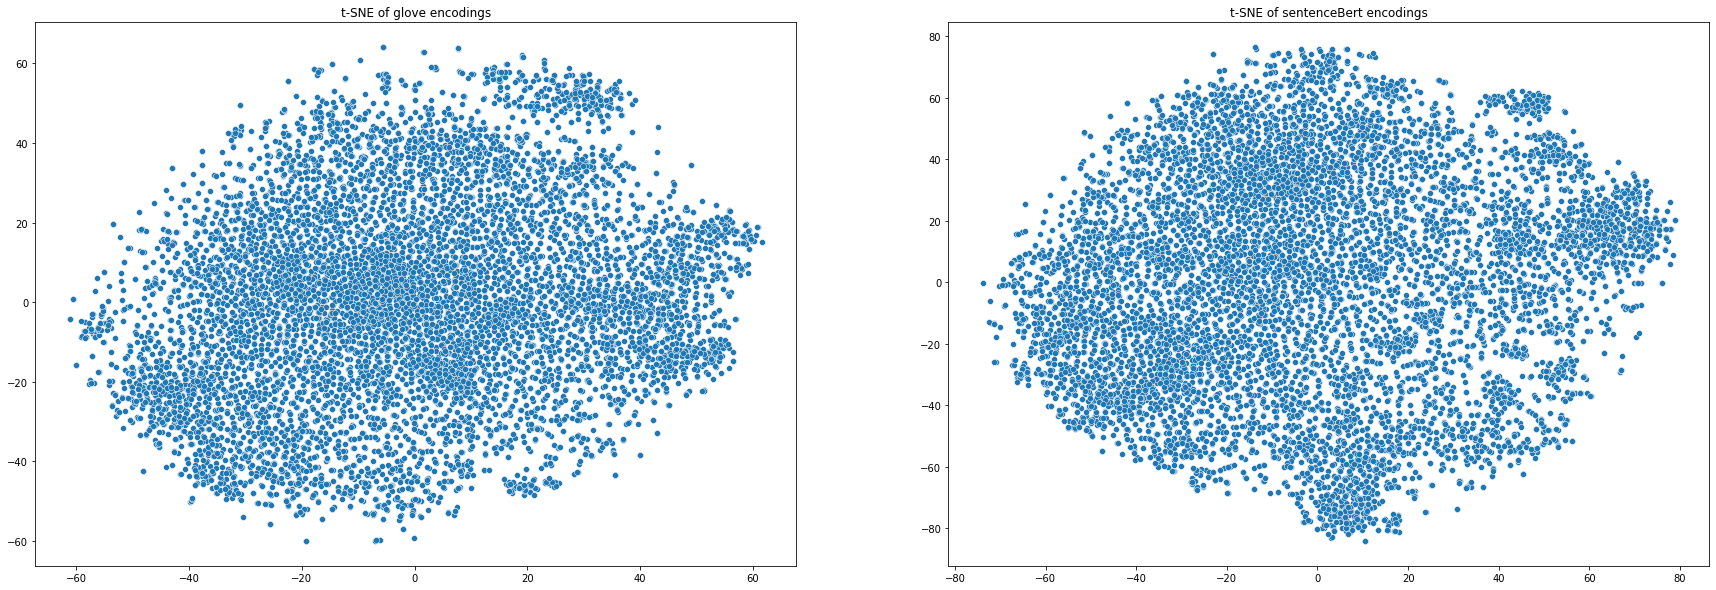

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30,10))
sns.scatterplot(x = tsne_mat_glove[:,0],y = tsne_mat_glove[:,1],ax = axes[0]).set(title='t-SNE of glove encodings')
sns.scatterplot(x = tsne_mat_bert[:,0],y = tsne_mat_bert[:,1],ax = axes[1]).set(title='t-SNE of sentenceBert encodings')
plt.show()

### Running K Means on Glove Encodings across various clusters 

In [ ]:
sil = []
maxRange = 50
db = []
ch = []
X = glove_encodings
for i in range(2,maxRange):
    model = KMeans(n_clusters=i, random_state=20,init = 'k-means++',algorithm = 'full')
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    ch_score = calinski_harabasz_score(X, cluster_labels)
    db_score = davies_bouldin_score(X, cluster_labels)
    print('\ni = :',i)
    print("Silhoutte: ",silhouette_avg)
    print("Calinski Harabasz Score: ", ch_score)
    print("Davies Bouldin Score: ",db_score )
    sil.append(silhouette_avg)
    ch.append(ch_score)
    db.append(db_score)



i = : 2
Silhoutte:  0.041940648
Calinski Harabasz Score:  392.0909338622173
Davies Bouldin Score:  4.6795958058065175

i = : 3
Silhoutte:  0.029453317
Calinski Harabasz Score:  324.45772071191766
Davies Bouldin Score:  4.387234337210397

i = : 4
Silhoutte:  0.027205382
Calinski Harabasz Score:  281.9920816628932
Davies Bouldin Score:  4.1274987066805995

i = : 5
Silhoutte:  0.028760541
Calinski Harabasz Score:  254.27154043651362
Davies Bouldin Score:  4.094752972721002

i = : 6
Silhoutte:  0.025321439
Calinski Harabasz Score:  226.65964441228937
Davies Bouldin Score:  4.197880108442252

i = : 7
Silhoutte:  0.027006706
Calinski Harabasz Score:  205.88137597312857
Davies Bouldin Score:  4.033978480272167

i = : 8
Silhoutte:  0.027243514
Calinski Harabasz Score:  190.2494827562049
Davies Bouldin Score:  4.065245937218611

i = : 9
Silhoutte:  0.021938194
Calinski Harabasz Score:  175.5783110771093
Davies Bouldin Score:  4.17928058285046

i = : 10
Silhoutte:  0.021618268
Calinski Harabasz

In [ ]:
results_golve_kmeans = pd.DataFrame({'i':list(range(2,maxRange)),'Silhoutte_Score':sil,'CH_Score':ch,'DB_Score':db})
results_golve_kmeans.to_csv("golve_kmeans.csv")

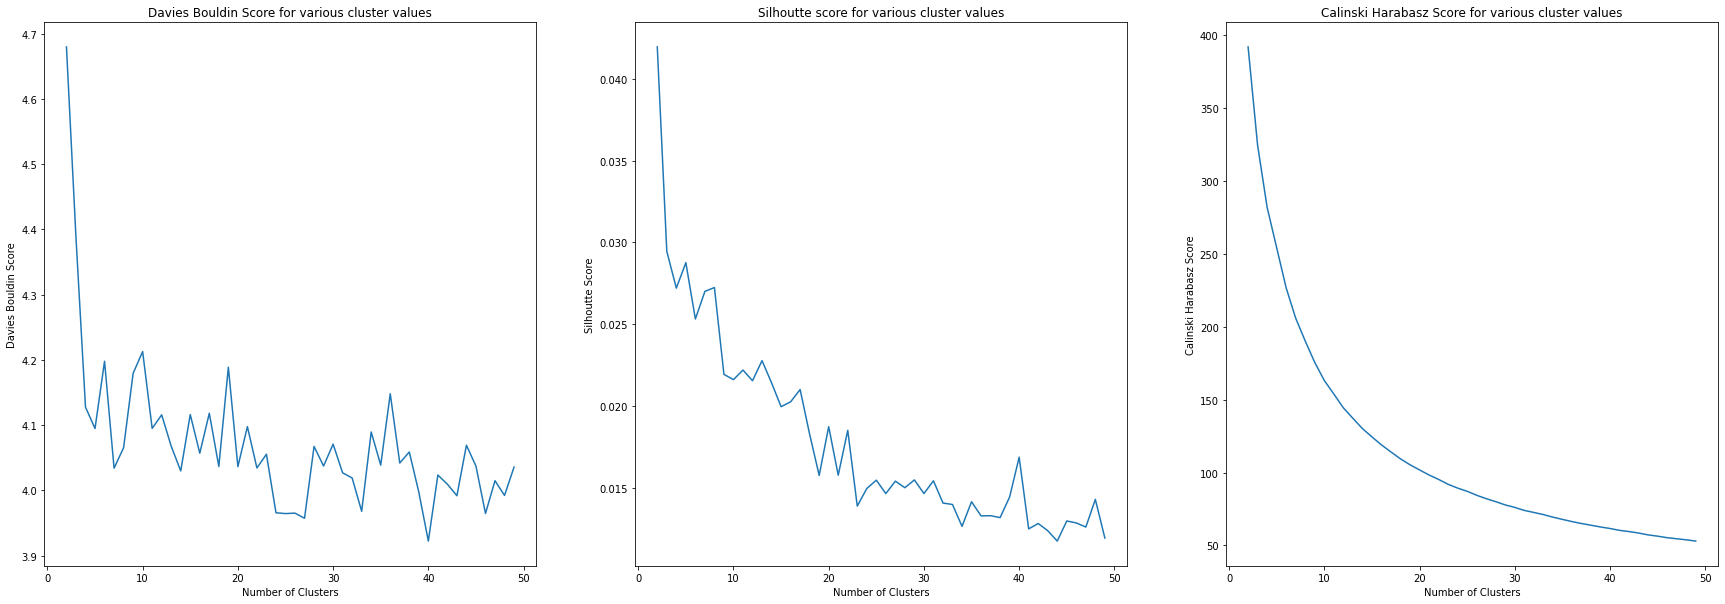

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))
axes[0].plot(list(range(2,maxRange)),db)
axes[0].set_title("Davies Bouldin Score for various cluster values")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Davies Bouldin Score")

axes[1].plot(list(range(2,maxRange)),sil)
axes[1].set_title("Silhoutte score for various cluster values")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhoutte Score")

axes[2].plot(list(range(2,maxRange)),ch)
axes[2].set_title("Calinski Harabasz Score for various cluster values")
axes[2].set_xlabel("Number of Clusters")
axes[2].set_ylabel("Calinski Harabasz Score")
plt.show()

###Running K Means on SentenceBert Encodings across various clusters

In [ ]:
sil = []
maxRange = 50
db = []
ch = []
X = bert_X
for i in range(2,maxRange):
    model = KMeans(n_clusters=i, random_state=20,init = 'k-means++',algorithm = 'full')
    cluster_labels = model.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    ch_score = calinski_harabasz_score(X, cluster_labels)
    db_score = davies_bouldin_score(X, cluster_labels)
    print('i = :',i)
    print("Silhoutte: ",silhouette_avg)
    print("Calinski Harabasz Score: ", ch_score)
    print("Davies Bouldin Score: ",db_score )
    sil.append(silhouette_avg)
    ch.append(ch_score)
    db.append(db_score)

i = : 2
Silhoutte:  0.05285057188249785
Calinski Harabasz Score:  508.16828364873027
Davies Bouldin Score:  4.125762063845601
i = : 3
Silhoutte:  0.046381739226721785
Calinski Harabasz Score:  435.1623311798105
Davies Bouldin Score:  3.7949136732022937
i = : 4
Silhoutte:  0.04365847812391016
Calinski Harabasz Score:  358.61817841833255
Davies Bouldin Score:  3.8213564386138192
i = : 5
Silhoutte:  0.036839297919281935
Calinski Harabasz Score:  318.0706190447965
Davies Bouldin Score:  3.698964582545339
i = : 6
Silhoutte:  0.03864913401397846
Calinski Harabasz Score:  285.73407303751884
Davies Bouldin Score:  3.799150836172295
i = : 7
Silhoutte:  0.034090458104447184
Calinski Harabasz Score:  261.16859976313003
Davies Bouldin Score:  3.6434446088102264
i = : 8
Silhoutte:  0.03305176631668706
Calinski Harabasz Score:  240.76304855181766
Davies Bouldin Score:  3.6357684435193516
i = : 9
Silhoutte:  0.030943224668232443
Calinski Harabasz Score:  222.63568244753552
Davies Bouldin Score:  3.68

In [ ]:
results_bert_kmeans = pd.DataFrame({'i':list(range(2,maxRange)),'Silhoutte_Score':sil,'CH_Score':ch,'DB_Score':db})
results_bert_kmeans.to_csv("bert_kmeans.csv")

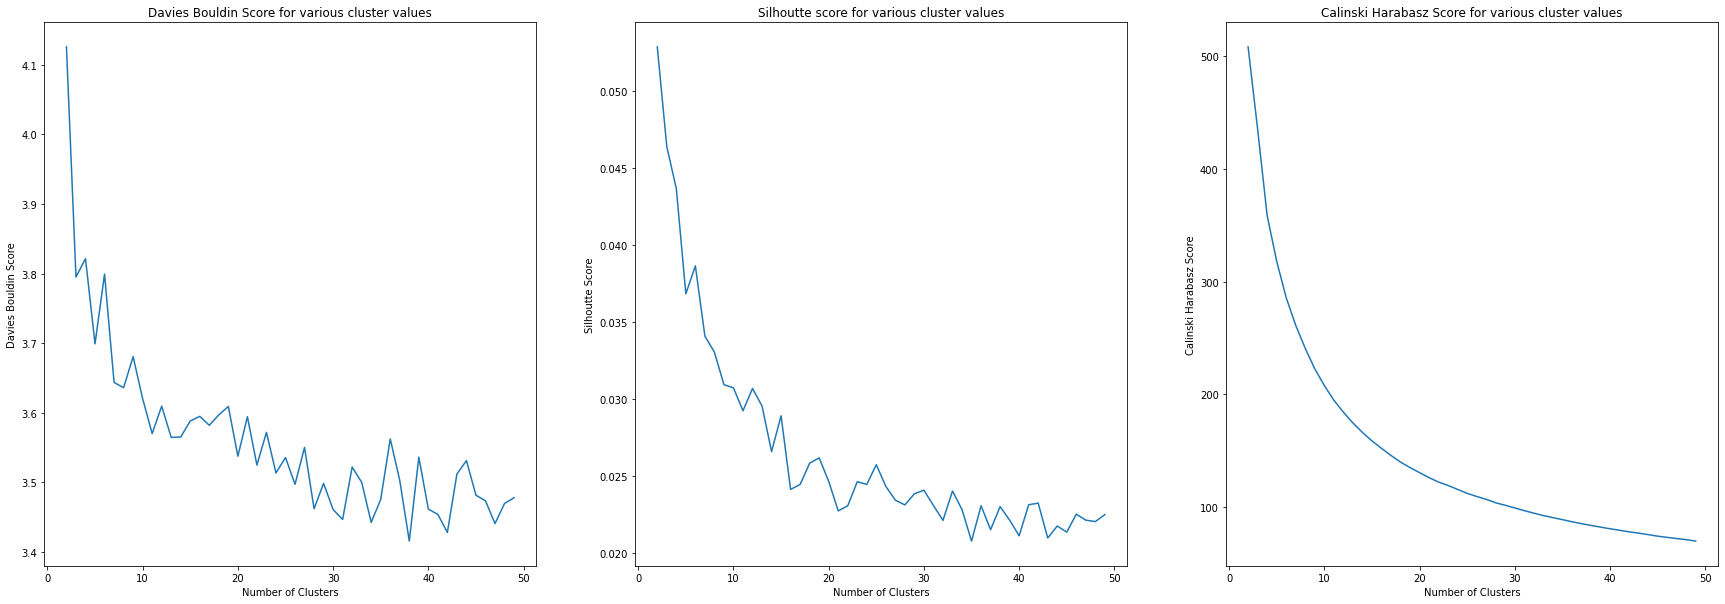

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))
axes[0].plot(list(range(2,maxRange)),db)
axes[0].set_title("Davies Bouldin Score for various cluster values")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Davies Bouldin Score")

axes[1].plot(list(range(2,maxRange)),sil)
axes[1].set_title("Silhoutte score for various cluster values")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Silhoutte Score")

axes[2].plot(list(range(2,maxRange)),ch)
axes[2].set_title("Calinski Harabasz Score for various cluster values")
axes[2].set_xlabel("Number of Clusters")
axes[2].set_ylabel("Calinski Harabasz Score")
plt.show()

In [ ]:

model = KMeans(n_clusters=15, random_state=100, algorithm = 'full')
cluster_labels = model.fit_predict(bert_X)
silhouette_avg = silhouette_score(bert_X, cluster_labels)
silhouette_avg = silhouette_score(X, cluster_labels)
ch_score = calinski_harabasz_score(X, cluster_labels)
db_score = davies_bouldin_score(X, cluster_labels)

print("Silhoutte: ",silhouette_avg)
print("Calinski Harabasz Score: ", ch_score)
print("Davies Bouldin Score: ",db_score )


Silhoutte:  0.025480929316131072
Calinski Harabasz Score:  158.80608901202075
Davies Bouldin Score:  3.549120867924243


In [ ]:
#Checking Cluster distribution
netflix_titles['cluster'] = cluster_labels

netflix_titles['cluster'].value_counts()

14    801
11    764
3     689
0     663
2     657
7     618
13    604
4     596
8     588
5     576
10    565
1     514
12    448
9     394
6     330
Name: cluster, dtype: int64

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


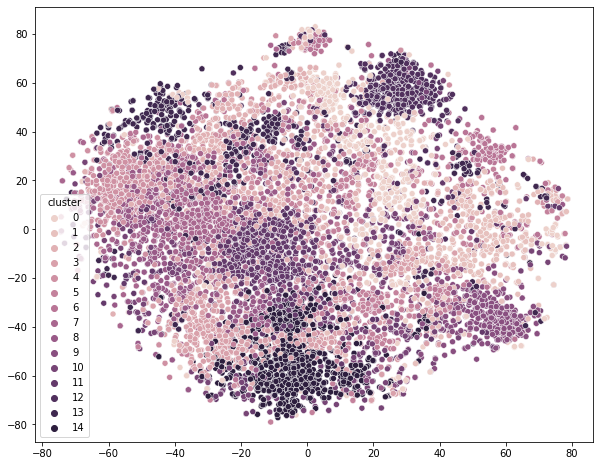

In [ ]:
tsne = TSNE(n_components=2)
tsne_mat = tsne.fit_transform(bert_X)
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1],hue=netflix_titles['cluster'],legend = 'full')

In [ ]:
netflix_titles_org = pd.read_csv("netflix_titles.csv")
print("Shape of the dataset: ",netflix_titles.shape)
netflix_titles_org['cluster'] = cluster_labels
netflix_titles_org.head()

Shape of the dataset:  (8807, 13)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,cluster
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",11
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",13
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,14
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",3
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,6


In [ ]:
random_data = netflix_titles_org[netflix_titles_org['cluster'] == 5].sample(10,random_state = 10)[['title','description']]
for desc,title in zip(random_data['description'],random_data['title']):
  print(title)
  print(desc)
  print('\n')

Dragonheart: A New Beginning
This sequel introduces Draco the dragon's offspring, Drake, who dreams of becoming a knight and teams up with a stable boy to master his skills.


Once a Gangster
Two former triads are tapped to run in an election for leader of the underworld, but both want normal lives. Each must outwit the other to lose.


The Best of Enemies
In 1971, a summit on school integration in North Carolina pits a civil rights activist against a Ku Klux Klan leader, sparking an unlikely friendship.


Iqbal
A boy with a hearing and speech impairment – and extraordinary athletic ability – chases his lifelong dream of playing cricket for India.


Undefeated
An inspirational profile of an inner-city high school football team's valiant effort to reach the school's first-ever playoff game.


Mossad 101
Cadets from every level of Israeli society undergo intense training to join their country's elite, highly classified intelligence service, the Mossad.


Illang: The Wolf Brigade
In 2029,

In [ ]:
netflix_titles_org.to_csv("netflix_titles_bert_KM.csv")